In [108]:
import os
import torch
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import DataLoader, SequentialSampler

from datasets import SASRecDataset
from models import S3RecModel
from trainers import FinetuneTrainer

In [109]:
from utils import (
    check_path,
    generate_submission_file,
    get_item2attribute_json,
    get_user_seqs,
    set_seed,
    __save_labels
)

In [110]:
from collections import namedtuple
args = namedtuple("Config", [])

In [135]:
args.data_dir = "../../../data/train/"
args.output_dir = "output/"
args.data_name  = "rb"
args.model_name = "Finetune_full"
args.hidden_size = 64 # hidden size of transformer model
args.num_hidden_layers = 3 #2 # number of layers
args.num_attention_heads = 2 # num_attention_heads
args.hidden_act = "gelu"
args.attention_probs_dropout_prob = 0.5 # attention dropout p
args.hidden_dropout_prob = 0.5 # hidden dropout p
args.initializer_range=0.02
args.max_seq_length=500 #300 #50

# train args
args.lr=0.001 # "learning rate of adam"
args.batch_size= 256 #256 # number of batch_size"
args.epochs=200#"number of epochs")
args.log_freq=1 #per epoch print res")
args.seed=42
args.weight_decay=0.0 #, help="weight_decay of adam"
args.adam_beta1=0.9 #"adam first beta value"
args.adam_beta2=0.999 #"adam second beta value"
args.gpu_id="0"#"gpu_id"

In [136]:
set_seed(args.seed)
check_path(args.output_dir) # output_dir 로 설정한 경로가 없으면 생성

In [137]:
args.no_cuda = False # gpu 있음
os.environ["CUDA_VISIBLE_DEVICES"] = args.gpu_id
args.cuda_condition = torch.cuda.is_available() and not args.no_cuda

In [138]:
args.data_file = args.data_dir + "train_ratings.csv"
item2attribute_file = args.data_dir + args.data_name + "_item2attributes.json"

In [139]:
le = LabelEncoder()
label_path = os.path.join(args.output_dir, "item" + "_classes.npy") # args.asset_dir -> args.output_dir
le.classes_ = np.load(label_path)

In [140]:
# save model args
args_str = f"{args.model_name}-{args.data_name}"

# print(args)

# args.item2attribute = item2attribute

# args.train_matrix = submission_rating_matrix

checkpoint = args_str + ".pt"
args.checkpoint_path = os.path.join(args.output_dir, checkpoint)
print(args.checkpoint_path)

output/Finetune_full-rb.pt


In [141]:
# 따로 저장해야하는 것들
# max_item # 
user_seq, rating_seq, max_item, valid_rating_matrix, test_rating_matrix, _ = get_user_seqs(
    args, # args.data_file, args.output_dir
    is_train = False
)
item2attribute, attribute_size = get_item2attribute_json(item2attribute_file)


In [142]:
args.item_size = max_item + 2
args.mask_id = max_item + 1
args.attribute_size = attribute_size + 1

In [143]:
model = S3RecModel(args=args)

In [144]:
file_name = args.checkpoint_path
model.load_state_dict(torch.load(file_name))

<All keys matched successfully>

In [145]:
model = model.to(device="cuda:0")

In [146]:
args.data_file

'../../../data/train/train_ratings.csv'

In [147]:
# ### get user seq from test dataset
# test_input_file = "../../../data/test/test_input_ratebeer_without_text.csv"
# rating_df = pd.read_csv(test_input_file)

# test_output_file = "../../../data/test/test_output_ratebeer_without_text.csv"
# out_rating_df = pd.read_csv(test_output_file)

In [148]:
# # label decoding
# rating_df = rating_df[["user_id", "beer_id", "review_score", "review_time"]].sort_values(["user_id", "review_time"])
# rating_df.columns = ["user", "item", "rating", "time"]
# rating_df.index = range(len(rating_df))

In [149]:
# rating_df["item"] = le.transform(rating_df["item"])

In [150]:
# lines_item = rating_df.groupby("user")["item"].apply(list)
# lines_rating = rating_df.groupby("user")["rating"].apply(list)

# user_seq = []
# rating_seq = []

# for line_item, line_rating in zip(lines_item, lines_rating):
#     items = line_item
#     user_seq.append(items)
#     ratings = line_rating
#     rating_seq.append(ratings)

In [151]:
from torch.utils.data import Dataset

class TestDataset(Dataset):
    def __init__(self, args, test_dir = "../../../data/test"):

        self.max_len = args.max_seq_length

        # load data set
        self.test_input_path = test_dir + "/test_input_ratebeer_without_text_limit30.csv"
        self.test_output_path = test_dir + "/test_output_ratebeer_without_text_limit30.csv"

        le = LabelEncoder()
        label_path = os.path.join(args.output_dir, "item" + "_classes.npy") # args.asset_dir -> args.output_dir
        le.classes_ = np.load(label_path)

        input_df = pd.read_csv(self.test_input_path)[["user_id", "beer_id", "review_score", "review_time"]].sort_values(["user_id", "review_time"])
        input_df.columns = ["user", "item", "rating", "time"]
        input_df["item"] = le.transform(input_df["item"])
        input_df.index = range(len(input_df))

        output_df = pd.read_csv(self.test_output_path)[["user_id", "beer_id", "review_score", "review_time"]].sort_values(["user_id", "review_time"])
        output_df.columns = ["user", "item", "rating", "time"]
        output_df["item"] = le.transform(output_df["item"])
        output_df.index = range(len(output_df))

        input_lines_item = input_df.groupby("user")["item"].apply(list)
        input_lines_rating = input_df.groupby("user")["rating"].apply(list)

        output_lines_item = output_df.groupby("user")["item"].apply(list)
        output_lines_rating = output_df.groupby("user")["rating"].apply(list)

        self.input_user_seq = []
        self.input_rating_seq = []
        self.output_user_seq = []
        self.output_rating_seq = []

        for i_line_item, i_line_rating, o_line_item, o_line_rating in zip(
                                                                        input_lines_item, 
                                                                        input_lines_rating, 
                                                                        output_lines_item, 
                                                                        output_lines_rating):
            items, ratings, o_items, o_ratings = i_line_item, i_line_rating, o_line_item, o_line_rating
            self.input_user_seq.append(items)
            self.input_rating_seq.append(ratings)
            self.output_user_seq.append(o_items)
            self.output_rating_seq.append(o_ratings)

        self.num_users = len(self.input_user_seq)

    def __len__(self):
        return self.num_users # i/o 유저의 수

    def __getitem__(self, index):
        user_id = index
        input_item_seq = self.input_user_seq[user_id]
        input_item_rating = self.input_rating_seq[user_id]
        output_item_seq = self.output_user_seq[user_id]
        output_item_ratings = self.output_rating_seq[user_id]
        # print(len(input_item_seq), len(input_item_rating), len(output_item_seq), len(output_item_ratings))

        pad_len = self.max_len - len(input_item_seq)
        input_item_seq = [0] * pad_len + input_item_seq
        input_item_rating = [0] * pad_len + input_item_rating

        pad_len = self.max_len - len(output_item_seq)
        output_item_seq = [0] * pad_len + output_item_seq
        output_item_ratings = [0] * pad_len + output_item_ratings

        input_item_seq = input_item_seq[-self.max_len :]
        input_item_rating = input_item_rating[-self.max_len :]
        output_item_seq = output_item_seq[-self.max_len :]
        output_item_ratings = output_item_ratings[-self.max_len :]

        cur_tensors = (
            torch.tensor(input_item_seq, dtype=torch.long), # batch_size * max_seq * emb
            torch.tensor(input_item_rating, dtype=torch.float32), # batch_size * max_seq * emb
            torch.tensor(output_item_seq, dtype=torch.long), # batch_size * n_answer
            torch.tensor(output_item_ratings, dtype=torch.float32) # batch_size * n_answer
        )

        return cur_tensors #(input_item_seq, input_item_rating, output_item_seq, output_item_ratings)

    


In [152]:
test_dataset = TestDataset(args)
test_sampler = SequentialSampler(test_dataset)
test_dataloader = DataLoader(
    test_dataset, sampler=test_sampler, batch_size=args.batch_size, drop_last=False
)

In [153]:
device = "cuda:0"

rating_pred_list = []
rating_true_list = []
model.eval()
for batch in test_dataloader:
    # print(batch)
    batch = tuple(t.to(device) for t in batch)

    input_items, input_ratings, output_items, ouput_ratings = batch
    recommend_output = model.finetune(input_items,  input_ratings) ############## TODO
    recommend_output = recommend_output[:, -1, :]
        
    # recommend_output : 시퀀스의 마지막 시점에 소비한 맥주까지 포함하여 다른 맥주와의 상호작용을 확인하는 임베딩 벡터 # [batch hidden_size]
    # answers : 해당 유저의 뒤에서 두 번째 아이템   # [batch * 1]
    # ratings_answer : 해당 아이템을 해당 유저가 매길것으로 예상되는 점수 # [batch hidden_size]
    # print(output_items[output_items > 0])
    # print(output_items[output_items != -1])

    # print("recommend_output.size() :", recommend_output.size())
    # print("output_items.size() :", output_items.size())

    output_items_emb = model.item_embeddings(output_items)
    # print("output_items_emb.size() :", output_items_emb.size())

    rating_pred = torch.bmm(output_items_emb, recommend_output.unsqueeze(2)).squeeze(2)
    masking_non_value = (output_items != 0)

    rating_pred = rating_pred*masking_non_value

    rating_pred_list += rating_pred[masking_non_value].cpu().data.numpy().copy().tolist()    
    rating_true_list += ouput_ratings[masking_non_value].cpu().data.numpy().copy().tolist()


    # answers_emb = model.item_embeddings(answers).squeeze(1) # [batch * hidden_size]

    # print(answers_emb.size)
    # rating_pred = torch.sum(answers_emb * recommend_output, dim = 1)
    # print(rating_pred)

    # metric_fn = torch.nn.MSELoss()
    # score = metric_fn(rating_pred, ratings_answer.squeeze(1))
    # break

In [154]:
for i, (a, b) in enumerate(zip(rating_pred_list, rating_true_list)):
    print(round(a,3), round(b,3))
    if i == 100: break

1.72 1.7
2.252 1.6
2.143 1.9
1.585 1.7
3.262 3.0
2.534 2.0
1.733 2.5
3.634 3.2
3.192 2.7
3.024 2.1
3.387 3.9
3.518 3.5
2.59 3.0
2.698 1.6
2.203 0.5
3.198 3.0
3.03 3.6
3.753 3.8
2.215 2.3
3.571 3.7
3.021 2.9
3.29 2.2
2.315 1.5
3.637 3.6
1.728 1.9
1.64 1.5
3.6 3.9
3.017 2.9
2.921 3.2
3.652 3.9
3.755 3.6
3.567 2.9
2.1 1.5
3.52 3.0
2.587 2.7
2.506 2.7
2.534 2.8
3.551 3.6
1.735 2.5
2.271 2.9
2.2 1.6
2.771 2.6
2.197 2.0
3.195 3.1
2.104 1.5
2.241 2.2
3.512 3.1
3.554 3.3
3.018 3.4
1.917 1.9
2.298 2.4
2.083 2.9
3.523 4.0
3.216 2.4
3.564 4.3
3.61 4.3
4.154 4.0
3.397 3.3
3.271 3.1
2.583 2.8
3.383 3.1
2.138 2.1
3.549 3.7
1.972 1.8
2.517 2.0
3.28 3.0
2.756 2.3
3.433 3.2
2.196 1.9
2.36 1.3
2.179 2.2
3.616 2.9
2.573 2.8
1.979 1.4
2.88 3.2
2.661 3.1
3.52 2.6
3.293 2.7
2.243 1.9
2.206 1.4
3.746 3.6
4.023 4.1
4.316 4.4
4.049 3.6
3.171 3.5
2.656 3.1
3.515 3.8
2.319 2.0
3.511 2.9
2.529 1.9
2.198 1.5
3.262 2.6
2.196 2.0
3.599 4.1
3.427 3.4
3.183 3.1
3.176 3.4
2.096 2.9
2.35 2.2
2.289 2.1
1.581 0.8


In [155]:
def rmse(y_pred_arr, y_true_arr):
    return np.sqrt(((y_pred_arr - y_true_arr) ** 2).mean())

In [156]:
rating_pred_arr = np.array(rating_pred_list)
rating_true_arr = np.array(rating_true_list)

In [157]:
rmse(rating_pred_arr, rating_true_arr)

0.6891523763073946

In [134]:
len(rating_pred_arr)

5216

### 일반적인 것으로 
- 단순 평균
- 선형 모형

In [62]:
# 일반적인 함수로 테스트
train_df = pd.read_csv("/opt/ml/workspace/final-project-level3-recsys-10/data/standard/train_ratebeer_without_text.csv")

In [63]:
mean_model_df = train_df.groupby("beer_id")["review_score"].mean().reset_index()
mean_model_df.columns = ["beer_id", "pred_review_score"]
mean_model_df

,beer_id,pred_review_score
0,1,3.392965
1,2,2.705658
2,3,2.957895
3,4,2.926847
4,5,2.877323
...,...,...
9332,580686,4.100000
9333,614833,2.500000
9334,621308,2.775862
9335,632627,2.692105


In [64]:
test_mean_model_df = pd.read_csv("/opt/ml/workspace/final-project-level3-recsys-10/data/test/test_output_ratebeer_without_text_limit30.csv")
test_mean_model_df = test_mean_model_df[["beer_id", "review_score"]]
test_mean_model_df.columns = ["beer_id", "true_review_score"]
test_mean_model_df = test_mean_model_df.reset_index()
test_mean_model_df

,index,beer_id,true_review_score
0,0,37,1.9
1,1,709,1.6
2,2,473,1.7
3,3,742,1.7
4,4,1478,2.0
...,...,...,...
5211,5211,1762,3.9
5212,5212,75071,3.0
5213,5213,15438,1.8
5214,5214,4142,3.0


In [65]:
get_test_mean_model_df = test_mean_model_df.merge(mean_model_df, on = "beer_id", how = "inner")
get_test_mean_model_df = get_test_mean_model_df.sort_values("index")
get_test_mean_model_df.index = range(len(get_test_mean_model_df))
get_test_mean_model_df

,index,beer_id,true_review_score,pred_review_score
0,0,37,1.9,2.169665
1,1,709,1.6,2.262250
2,2,473,1.7,1.546999
3,3,742,1.7,1.793200
4,4,1478,2.0,2.545032
...,...,...,...,...
5211,5211,1762,3.9,3.590947
5212,5212,75071,3.0,3.147106
5213,5213,15438,1.8,1.995755
5214,5214,4142,3.0,3.037193


In [66]:
get_test_mean_model_df["model_based"] = rating_pred_arr
get_test_mean_model_df = get_test_mean_model_df[["beer_id", "true_review_score", "model_based", "pred_review_score"]]
get_test_mean_model_df

,beer_id,true_review_score,model_based,pred_review_score
0,37,1.9,1.861772,2.169665
1,709,1.6,2.378305,2.262250
2,473,1.7,2.247782,1.546999
3,742,1.7,1.627813,1.793200
4,1478,2.0,3.308063,2.545032
...,...,...,...,...
5211,1762,3.9,3.725508,3.590947
5212,75071,3.0,3.152730,3.147106
5213,15438,1.8,2.306458,1.995755
5214,4142,3.0,3.266449,3.037193


In [67]:
get_test_mean_model_df.head(50)

,beer_id,true_review_score,model_based,pred_review_score
0,37,1.9,1.861772,2.169665
1,709,1.6,2.378305,2.262250
2,473,1.7,2.247782,1.546999
3,742,1.7,1.627813,1.793200
4,1478,2.0,3.308063,2.545032
5,1088,3.2,2.626834,3.622456
6,2469,3.0,1.881970,3.232499
7,742,2.5,3.693736,1.793200
8,2468,2.7,3.258749,3.164677
9,390,2.1,3.081886,3.006325


In [68]:
rmse(get_test_mean_model_df["true_review_score"], get_test_mean_model_df["pred_review_score"])

0.6886543013486908

In [45]:
get_test_mean_model_df["model_based"] = rating_pred_arr

In [50]:
get_test_mean_model_df.head(60)

,beer_id,true_review_score,pred_review_score,model_based
0,37,1.9,2.169665,1.748652
1,37,2.3,2.169665,2.197562
2,37,2.4,2.169665,1.505415
3,37,1.9,2.169665,3.314546
4,37,1.9,2.169665,2.419085
5,37,2.1,2.169665,1.756427
6,37,2.0,2.169665,3.183325
7,37,2.0,2.169665,2.945865
8,37,1.7,2.169665,3.413313
9,37,1.7,2.169665,3.291302


In [64]:
test_df = pd.read_csv("/opt/ml/workspace/final-project-level3-recsys-10/data/standard/test_ratebeer_without_text.csv")

In [65]:
test_df = pd.read_csv("/opt/ml/workspace/final-project-level3-recsys-10/data/standard/test_ratebeer_without_text.csv")
test_df = test_df[["beer_id", "review_score"]]
test_df.columns = ["beer_id", "true_review_score"]
test_df = test_df.reset_index()
test_df

,index,beer_id,true_review_score
0,0,131594,4.0
1,1,131594,4.3
2,2,131594,4.1
3,3,131594,4.0
4,4,131594,3.4
...,...,...,...
314547,314547,3324,3.6
314548,314548,3324,4.0
314549,314549,3324,3.2
314550,314550,3324,2.4


In [66]:
get_test_df = test_df.merge(mean_model_df, on = "beer_id", how = "inner")
get_test_df = get_test_df.sort_values("index")
get_test_df.index = range(len(get_test_df))
get_test_df

,index,beer_id,true_review_score,pred_review_score
0,0,131594,4.0,3.986297
1,1,131594,4.3,3.986297
2,2,131594,4.1,3.986297
3,3,131594,4.0,3.986297
4,4,131594,3.4,3.986297
...,...,...,...,...
314547,314547,3324,3.6,3.105983
314548,314548,3324,4.0,3.105983
314549,314549,3324,3.2,3.105983
314550,314550,3324,2.4,3.105983


In [67]:
rmse(get_test_df["true_review_score"], get_test_df["pred_review_score"])

0.49836598385990016

In [69]:
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

In [70]:
vis_df = pd.DataFrame()
vis_df["n_reivew"] = [4, 5, 6,7,8,9,10]
vis_df["train_loss"] = [0.2070, 0.2171, 0.2255, 0.2322, 0.2786, 0.2463, 0.2498, ]
vis_df["valid_loss"] = [0.6540722695816826,0.6391370848640983,  0.6275069372834986, 0.6146579117214176, 0.601892774001176, 0.596786528646603, 0.5861596483093905]
vis_df["test_loss"] = [0.6597157165705253, 0.6448241189140903, 0.6301568233533358, 0.6209053274050548, 0.6113650325044774, 0.603757000929737, 0.5976322147157224]
vis_df["standard_test_rmse"] = [0.6890820635231829, 0.6871092050374961 ,0.6871329649760539, 0.6871676697874202, 0.6868523439775196, 0.6868592226874247, 0.6864957339861917]

vis_df

,n_reivew,train_loss,valid_loss,test_loss,standard_test_rmse
0,4,0.2070,0.654072,0.659716,0.689082
1,5,0.2171,0.639137,0.644824,0.687109
2,6,0.2255,0.627507,0.630157,0.687133
3,7,0.2322,0.614658,0.620905,0.687168
4,8,0.2786,0.601893,0.611365,0.686852
5,9,0.2463,0.596787,0.603757,0.686859
6,10,0.2498,0.586160,0.597632,0.686496


In [71]:
vis_melt_df = vis_df.melt(["n_reivew"], value_name="RMSE", var_name="Data type")
vis_melt_df

,n_reivew,Data type,RMSE
0,4,train_loss,0.207000
1,5,train_loss,0.217100
2,6,train_loss,0.225500
3,7,train_loss,0.232200
4,8,train_loss,0.278600
5,9,train_loss,0.246300
6,10,train_loss,0.249800
7,4,valid_loss,0.654072
8,5,valid_loss,0.639137
9,6,valid_loss,0.627507


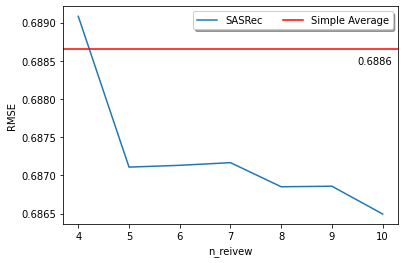

In [106]:
sns.lineplot(x = "n_reivew", y = "RMSE", data=vis_melt_df[vis_melt_df["Data type"]=="standard_test_rmse"])
plt.xticks(vis_df["n_reivew"])
plt.axhline(y = 0.6886543013486908, c="r")
plt.text(x=9.5, y=0.68845, s="0.6886")
plt.legend(["SASRec", "Simple Average"], ncol=2, frameon=True, shadow=True)
plt.show()

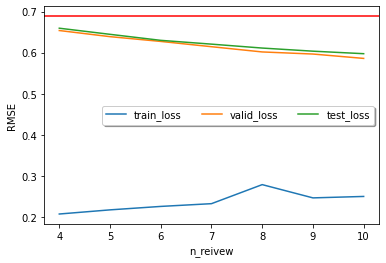

In [95]:
sns.lineplot(x = "n_reivew", y = "RMSE", data=vis_melt_df[vis_melt_df["Data type"]!="standard_test_rmse"], hue = "Data type")
plt.xticks(vis_df["n_reivew"])
plt.axhline(y = 0.6886543013486908, c="r")
plt.legend(ncol=3, frameon=True, shadow=True)
plt.show()

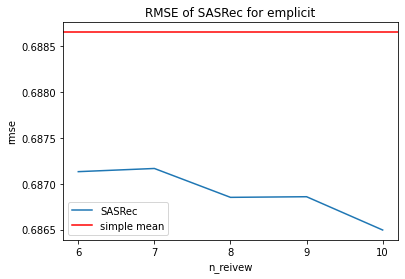

In [183]:
sns.lineplot(x = "n_reivew", y = "rmse", data=vis_df)
plt.xticks(vis_df["n_reivew"])
plt.axhline(y = 0.6886543013486908, c="r")
plt.title("RMSE of SASRec for emplicit")
# plt.legend({"model":"b", "simple mean":"r"})
plt.legend(["SASRec", "simple mean"])